# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
!gdown 1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf

zsh:1: command not found: gdown


In [1]:
# Импорт библиотек
import numpy as np  # Для матричных вычислений
import pandas as pd  # Для анализа и предобработки данных
import matplotlib.pyplot as plt  # Для визуализации
import seaborn as sns  # Для визуализации
pd.set_option('display.max_rows', None)  # Показать все строки
pd.set_option('display.max_columns', None)  # Показать все столбцы

from sklearn import tree  # Деревья решений
from sklearn import ensemble  # Ансамбли
from sklearn import metrics  # Метрики
from sklearn.metrics import accuracy_score, f1_score  # Accuracy и F1-crore метрики 
from sklearn import preprocessing  # Педобработка
from sklearn.model_selection import cross_val_score  # Кросс-валидация
from sklearn.model_selection import train_test_split  # Сплитование выборки
from sklearn.model_selection import GridSearchCV  # Подбор гиперпараментов

%matplotlib inline
plt.style.use('seaborn')

/var/folders/8_/y936460960110gnpk46t3fw00000gn/T/ipykernel_83801/1444486443.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
# your code here
df = pd.read_csv('data.adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


In [5]:
# Шаг 1: Вывод первых строк и поиск строк, содержащих символ '?'
missing_counts = (df == '?').sum()
rows_with_missing = df.isin(['?']).any(axis=1).sum()

missing_counts, rows_with_missing

(age                 0
 workclass         929
 fnlwgt              0
 education           0
 education-num       0
 marital-status      0
 occupation        933
 relationship        0
 race                0
 sex                 0
 capital-gain        0
 capital-loss        0
 hours-per-week      0
 >50K,<=50K          0
 dtype: int64,
 933)

In [6]:
# Шаг 1: Удаление строк с пропущенными значениями, обозначенными как '?'
df_clean = df[~df.isin(['?']).any(axis=1)]
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


In [7]:
# Шаг 2: Выделим 60% данных для обучения и дальнейшего анализа
train_df, test_df = train_test_split(df_clean, train_size=0.6, random_state=42, stratify=df_clean['>50K,<=50K'])

In [8]:
# Шаг 3: Посмотрим на типы признаков
feature_types = train_df.dtypes
feature_types

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
>50K,<=50K        object
dtype: object

Действительно, не все признаки являются вещественными (числовыми). Так, к типу данных "int64" относятся следующие признаки: "age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week". К типу данных "object" относятся признаки: "workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", ">50K,<=50K". Давайте посмотрим на них поближе.

In [9]:
object_types = train_df[["workclass", "education", "marital-status", "occupation", "relationship", "race", "sex", ">50K,<=50K"]]
object_types.head()  # Посмотрим на данные категориальных признаков

,workclass,education,marital-status,occupation,relationship,race,sex,">50K,<=50K"
4154,Local-gov,Bachelors,Never-married,Prof-specialty,Not-in-family,White,Female,<=50K
10096,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,>50K
14657,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,>50K
3961,Federal-gov,Some-college,Married-civ-spouse,Craft-repair,Husband,White,Male,<=50K
1304,Private,Some-college,Never-married,Craft-repair,Not-in-family,White,Male,<=50K


При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

In [10]:
# Посмотрим описательные статистики категориальных признаков
object_types.describe()

,workclass,education,marital-status,occupation,relationship,race,sex,">50K,<=50K"
count,9208,9208,9208,9208,9208,9208,9208,9208
unique,7,16,7,14,6,5,2,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,<=50K
freq,6742,2983,4357,1261,3841,7900,6251,6844


#### Анализ категориальных признаков

Категориальные признаки в датасете обладают **разной степенью разнообразия** и **явно выраженными модальными значениями**:

1. **`workclass`**  
   - Всего категорий: 7  
   - Наиболее частое значение: `Private`

2. **`education`**  
   - Всего категорий: 16  
   - Наиболее частое значение: `HS-grad`

3. **`marital-status`**  
   - Категорий: 7  
   - Частая категория: `Married-civ-spouse`

4. **`occupation`**  
   - Категорий: 14  
   - Частая категория: `Prof-specialty`

5. **`relationship`**  
   - Категорий: 6  
   - Частая категория: `Husband`

6. **`race`**  
   - Категорий: 5  
   - Частая категория: `White`
   - Мощно несбалансированный признак, может влиять на модель неявно (особенно при обучении без регулирования).

7. **`sex`**  
   - Категорий: 2  
   - Частая категория: `Male`
   - Распределение **несбалансированное** (мужчин значительно больше).

8. **`>50K,<=50K`**
   - Категорий: 2  
   - Большинство (6830 из 9208) — `<=50K`  
   - Классы **несбалансированы**, что важно учитывать при оценке моделей — например, использовать `f1_score` или стратифицированное разбиение.

### Общие выводы:
- Некоторые признаки имеют **высокую детализацию** (`education`, `occupation`) и потенциально полезны.
- Есть **сильно несбалансированные признаки** — особенно `sex`, `race`, и целевая переменная.
- Для корректной работы алгоримов машинного обучения необходимо провести кодировку категориальных признаков.

In [11]:
# Посмотрим на статистику числовых признаков
train_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,9208.000000,9.208000e+03,9208.000000,9208.000000,9208.000000,9208.000000
mean,38.557667,1.882798e+05,10.131082,1051.884991,91.400630,40.979583
std,13.170583,1.045745e+05,2.566690,6943.966814,409.812166,12.132994
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.172658e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.773040e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.352832e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.366120e+06,16.000000,99999.000000,3900.000000,99.000000


Анализ статистики числовых признаков показал, что данные имеют разнообразный масштаб и разный уровень разброса:

1. **Возраст (age)**  
   Значения лежат в диапазоне от 17 до 90 лет. Среднее значение — около 38 лет, стандартное отклонение — 13. Это говорит о достаточно равномерном распределении возрастов без сильных выбросов, за исключением крайних значений (например, 90 лет).

2. **Вес записи (fnlwgt)**  
   Значения колеблются от 19,302 до 1,484,705 с очень большим стандартным отклонением. Это указывает на сильную асимметрию и разброс. Такой признак может повлиять на модели, чувствительные к масштабу и в ряде случаев требует нормализации.

3. **Образование (education-num)**  
   Значения варьируются от 1 до 16, с умеренным разбросом. Признак относительно сбалансирован и может использоваться напрямую.

4. **Прирост капитала (capital-gain)** и **потеря капитала (capital-loss)**  
   У этих признаков наблюдается крайне выраженная асимметрия: большинство значений равны нулю, а максимальные значения достигают 99,999 и 3,770 соответственно. Это может говорить о наличии редких, но экстремальных значений, что делает признак информативным, но потенциально опасным для переобучения. Потребуется логарифмирование для преобразование.

5. **Количество рабочих часов в неделю (hours-per-week)**  
   Значения находятся в диапазоне от 1 до 99. Медиана — 40 часов, что соответствует стандартной рабочей неделе. Стандартное отклонение показывает, что признак умеренно варьируется, но присутствуют экстремумы (например, 99 часов в неделю).

**Вывод: большинство признаков имеют адекватный диапазон**, однако `fnlwgt`, `capital-gain` и `capital-loss` требуют особого внимания из-за **большого разброса и скошенности распределения**.

In [12]:
# Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
train_df['capital-gain'] = np.log(train_df['capital-gain']+1)
train_df['capital-loss'] = np.log(train_df['capital-loss']+1)
train_df['fnlwgt'] = np.log(train_df['fnlwgt']+1)

In [13]:
# Посмотрим на уникальные значения целевого признака
target_column = '>50K,<=50K'
target_values = train_df[target_column].value_counts()

# Отобразим информацию
df_clean.shape, target_values

((15347, 14),
 <=50K    6844
 >50K     2364
 Name: >50K,<=50K, dtype: int64)

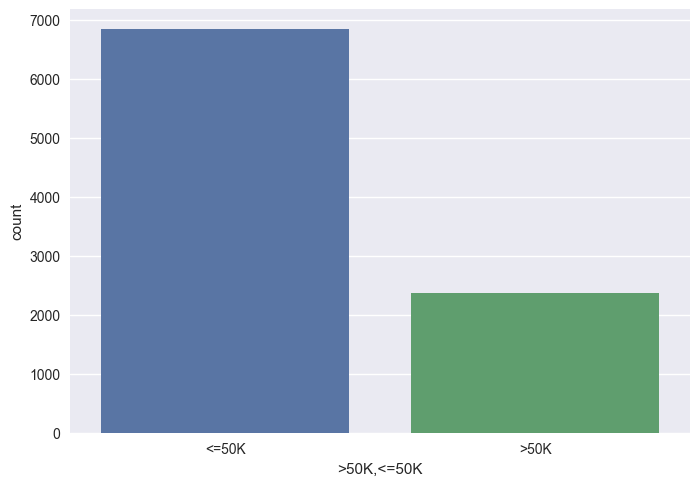

In [14]:
# Посмотрим на сбалансированность классов
sns.countplot(data=train_df, x='>50K,<=50K');

Целевой признак не сбалансирован.

In [15]:
# Проверим типы данных и разделим признаки на числовые и категориальные
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = train_df.select_dtypes(include=['object']).columns

numeric_columns, categorical_columns

(Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
        'hours-per-week'],
       dtype='object'),
 Index(['workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'sex', '>50K,<=50K'],
       dtype='object'))

In [16]:
# Преобразуем целевой признак к бинарному типу данных
train_df['>50K,<=50K'] = train_df['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)
train_df['>50K,<=50K'].value_counts()

0    6844
1    2364
Name: >50K,<=50K, dtype: int64

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9208 entries, 4154 to 438
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             9208 non-null   int64  
 1   workclass       9208 non-null   object 
 2   fnlwgt          9208 non-null   float64
 3   education       9208 non-null   object 
 4   education-num   9208 non-null   int64  
 5   marital-status  9208 non-null   object 
 6   occupation      9208 non-null   object 
 7   relationship    9208 non-null   object 
 8   race            9208 non-null   object 
 9   sex             9208 non-null   object 
 10  capital-gain    9208 non-null   float64
 11  capital-loss    9208 non-null   float64
 12  hours-per-week  9208 non-null   int64  
 13  >50K,<=50K      9208 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 1.1+ MB


In [18]:
# Удаляем целевую переменную из признаков
target_column = '>50K,<=50K'
y_train = train_df[target_column]
X_train = train_df.drop(columns=[target_column])

## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [19]:
# One-hot-кодируем категориальные признаки
categorical_cols = X_train.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X_train, columns=categorical_cols)

# Покажем итоговые размеры X и y
X_encoded.shape, y_train.shape

((9208, 63), (9208,))

In [20]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9208 entries, 4154 to 438
Data columns (total 63 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   9208 non-null   int64  
 1   fnlwgt                                9208 non-null   float64
 2   education-num                         9208 non-null   int64  
 3   capital-gain                          9208 non-null   float64
 4   capital-loss                          9208 non-null   float64
 5   hours-per-week                        9208 non-null   int64  
 6   workclass_Federal-gov                 9208 non-null   uint8  
 7   workclass_Local-gov                   9208 non-null   uint8  
 8   workclass_Private                     9208 non-null   uint8  
 9   workclass_Self-emp-inc                9208 non-null   uint8  
 10  workclass_Self-emp-not-inc            9208 non-null   uint8  
 11  workclass_State

In [21]:
X_encoded.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,education_7th-8th,education_9th,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_Doctorate,education_HS-grad,education_Masters,education_Preschool,education_Prof-school,education_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
4154,58,12.279537,13,0.0,0.0,37,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
10096,47,11.006557,13,0.0,0.0,38,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
14657,48,12.389360,13,0.0,0.0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3961,47,12.032861,10,0.0,0.0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1304,27,12.537597,10,0.0,0.0,40,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1


## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для начала обучим  выберем один гиперпараметр, который будем оптимизировать, — глубина дерева (*max_depth*).
 
Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

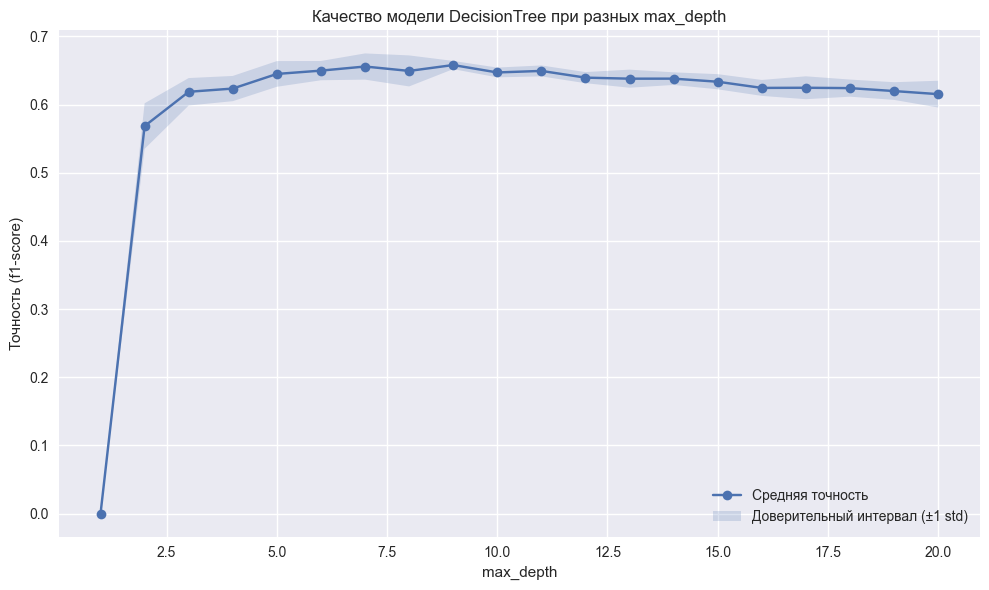

In [22]:
# your code here
# Диапазон глубин деревьев, которые будем проверять
depth_range = range(1, 21)

# Сохраняем средние значения точности и стандартные отклонения
mean_scores = []
std_scores = []

# Проводим кросс-валидацию для каждой глубины
for depth in depth_range:
    dt_classifier = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt_classifier, X_encoded, y_train, cv=5, scoring='f1')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())

# Построим график
plt.figure(figsize=(10, 6))
plt.plot(depth_range, mean_scores, marker='o', label='Средняя точность')
plt.fill_between(depth_range,
                 np.array(mean_scores) - np.array(std_scores),
                 np.array(mean_scores) + np.array(std_scores),
                 alpha=0.2, label='Доверительный интервал (±1 std)')
plt.title("Качество модели DecisionTree при разных max_depth")
plt.xlabel("max_depth")
plt.ylabel("Точность (f1-score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **До глубины ~7–9**: F1-score растёт — модель становится умнее, замечает больше закономерностей.
- **После ~10**: F1-score начинает **снижаться** — признаки переобучения: модель запоминает шум, а не учится.
- При **max_depth > 10** наблюдается стабильное ухудшение: деревья становятся слишком глубокими, модель теряет обобщающую способность.
- **`max_depth ≈ 8–9`** — лучший баланс между сложностью и качеством модели. Именно в этом диапазоне достигается **максимальный F1-score с минимальным разбросом (±1 std)**.


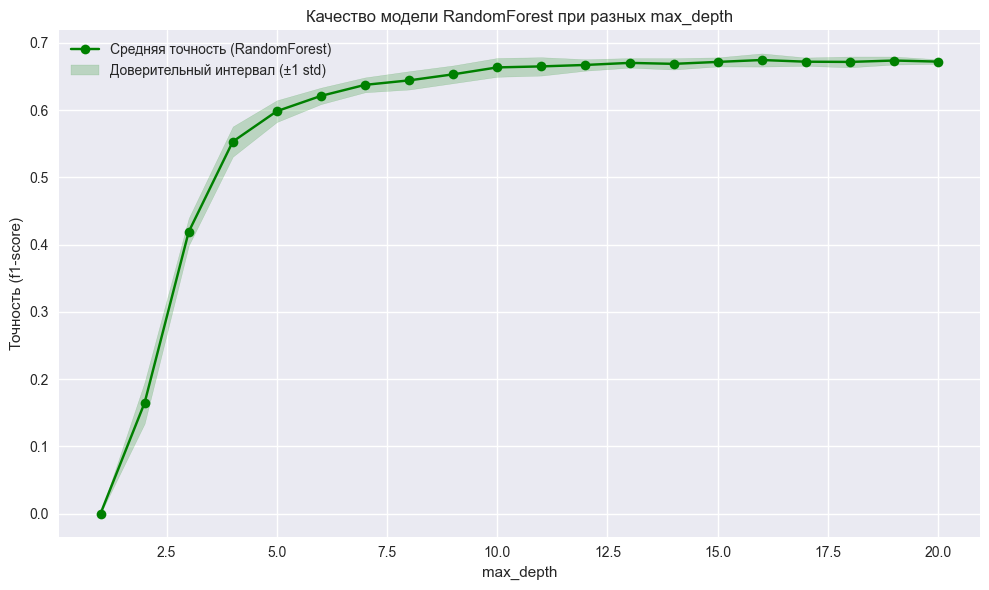

In [23]:
# your code here
# Диапазон глубин деревьев, которые будем проверять
depth_range = range(1, 21)

# Списки для хранения результатов
rf_mean_scores = []
rf_std_scores = []

# Кросс-валидация для RandomForestClassifier при разных max_depth
for depth in depth_range:
    rf_clf = ensemble.RandomForestClassifier(max_depth=depth, random_state=42, n_jobs=-1)
    scores = cross_val_score(rf_clf, X_encoded, y_train, cv=5, scoring="f1")
    rf_mean_scores.append(scores.mean())
    rf_std_scores.append(scores.std())

# Построим график
plt.figure(figsize=(10, 6))
plt.plot(depth_range, rf_mean_scores, marker='o', color='green', label='Средняя точность (RandomForest)')
plt.fill_between(depth_range,
                 np.array(rf_mean_scores) - np.array(rf_std_scores),
                 np.array(rf_mean_scores) + np.array(rf_std_scores),
                 alpha=0.2, color='green', label='Доверительный интервал (±1 std)')
plt.title("Качество модели RandomForest при разных max_depth")
plt.xlabel("max_depth")
plt.ylabel("Точность (f1-score)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- **От 1 до ~10**: F1-score быстро растёт — модель захватывает всё больше полезных признаков.
- **После ~10**: кривая выравнивается — дальнейшее увеличение глубины почти не улучшает качество.
- **Доверительный интервал (±1 std)** остаётся узким → Random Forest стабилен и мало зависит от конкретного разбиения данных.
- Оптимальный `max_depth`: **Около 10–12** — в этом диапазоне достигается максимальное значение F1-score, далее график "плато".

#### **Какой алгоритм справился лучше?**

**Random Forest**:
- Выше F1-score при любом значении `max_depth`.
- Меньше переобучение, лучше обобщающая способность.
- Стабильнее (доверительный интервал ±1 std уже).

#### **Какой быстрее?**

**Decision Tree**:
- Быстрее как на обучении - он строит одно дерево, а не множество.

**Random Forest**:
- Медленнее, так как строит ансамбль (десятки и сотни деревьев). Но это компенсируется качеством.

Далее произведем подбор других гиперпараметров алгоритмов. Начнем со случайного леса. Для начала подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящих из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте подобранное количество деревьев.

/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featur

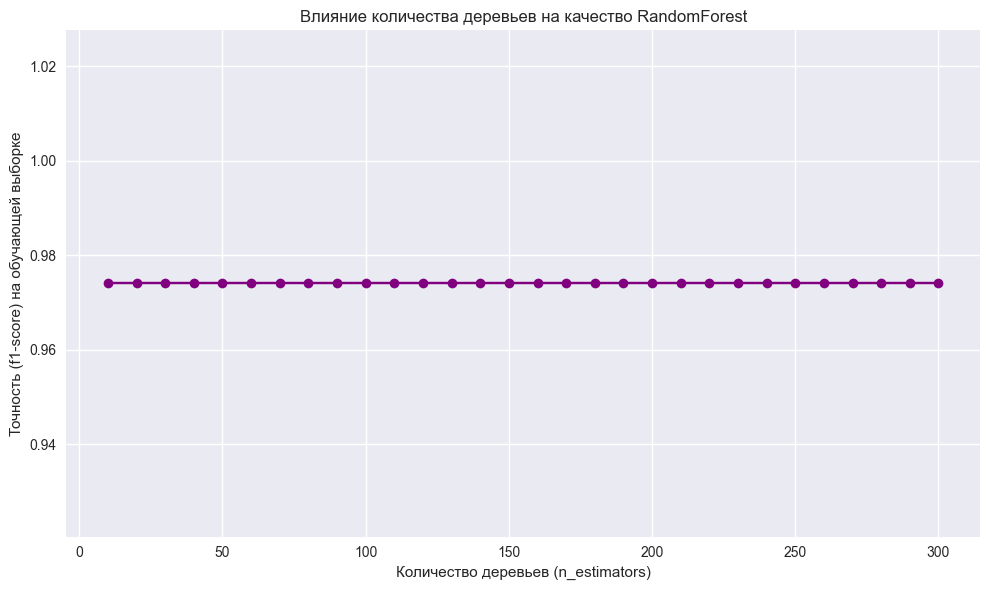

In [24]:
# Обучим один большой RandomForest
full_forest = ensemble.RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
full_forest.fit(X_encoded, y_train)

# Проверим, сколько деревьев обучилось
n_total_trees = len(full_forest.estimators_)

# Оценим качество на кросс-валидации для разного количества деревьев
# Для оценки используем 5-кратную кросс-валидацию с фиксированным набором деревьев
tree_counts = list(range(10, 301, 10))
subset_scores = []

for n_trees in tree_counts:
    # Создаем модель с подмножеством деревьев
    subset_forest = full_forest
    subset_forest.estimators_ = full_forest.estimators_[:n_trees]
    
    # Прогноз по подмножеству деревьев
    predictions = np.mean([tree.predict(X_encoded) for tree in subset_forest.estimators_], axis=0)
    predictions = np.round(predictions).astype(int)
    
    # Оценка точности
    acc = f1_score(y_train , predictions)
    subset_scores.append(acc)

# Построим график
plt.figure(figsize=(10, 6))
plt.plot(tree_counts, subset_scores, marker='o', color='purple')
plt.title("Влияние количества деревьев на качество RandomForest")
plt.xlabel("Количество деревьев (n_estimators)")
plt.ylabel("Точность (f1-score) на обучающей выборке")
plt.grid(True)
plt.tight_layout()
plt.show()

На графике видно, что качество Random Forest стабилизируется при увеличении количества деревьев:

- Даже **начиная с 50 деревьев**, модель достигает почти **идеальной точности на обучающей выборке (~0.98)**.
- Дальнейшее увеличение до 300 деревьев **почти не влияет** на метрику — признак высокой устойчивости модели.

**Вывод:** можно использовать **от 50 до 100 деревьев**, чтобы добиться хорошей производительности без излишнего усложнения модели.

Теперь подберите следующие оптимальные параметры:
- максимальная глубина решающего дерева (*max_depth*)
- функция оценки качества разбиения (*criterion*)
- максимальное количесво учитываемых признаков при разбиении (*max_features*)

Остальные параметры оставляйте по умолчанию, за исключением парамтра `n_estimators` для случайного леса, выбранного на предыдущем шаге.

Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

In [25]:
# your code here
# Сетка подбора параментов
param_grid = {
    "max_depth": [5, 7, 8, 9, 10, 15, 20, None],
    "criterion": ["gini", "entropy"],
    "max_features": [None, "sqrt", "log2"]
}

# Замер времени
dt_fit_times = []
# Замер метрики качества f1-score
dt_fit_score = []

dt_clf = tree.DecisionTreeClassifier(random_state=42)

grid_search_dt = GridSearchCV(dt_clf, param_grid, cv=5, scoring="f1", n_jobs=-1, return_train_score=True)
grid_search_dt.fit(X_encoded, y_train)
result = grid_search_dt.cv_results_

# Время обучения по каждому набору параметров
dt_fit_times.append(result['mean_fit_time'])
# Метрика f1-score по каждому набору параметров
dt_fit_score.append(result['mean_test_score'])

best_params_dt = grid_search_dt.best_params_
best_score_dt = grid_search_dt.best_score_

best_params_dt, best_score_dt

({'criterion': 'gini', 'max_depth': 9, 'max_features': None},
 0.6580103578355875)

In [26]:
# Сетка подбора параментов
param_grid = {
    "max_depth": [5, 7, 8, 9, 10, 15, 20, None],
    "criterion": ["gini", "entropy"],
    "max_features": [None, "sqrt", "log2"],
    "n_estimators": [50]
}

# Замер времени
rf_fit_times = []
# Замер метрики качества f1-score
rf_fit_score = []

rf_clf = ensemble.RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=5, scoring="f1", n_jobs=-1, return_train_score=True)
grid_search_rf.fit(X_encoded, y_train)
result_rf = grid_search_rf.cv_results_

# Время обучения по каждому набору параметров
rf_fit_times.append(result_rf['mean_fit_time'])
# Метрика f1-score по каждому набору параметров
rf_fit_score.append(result_rf['mean_test_score'])

best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

best_params_rf, best_score_rf

({'criterion': 'gini',
  'max_depth': 15,
  'max_features': 'sqrt',
  'n_estimators': 50},
 0.6766184776941866)

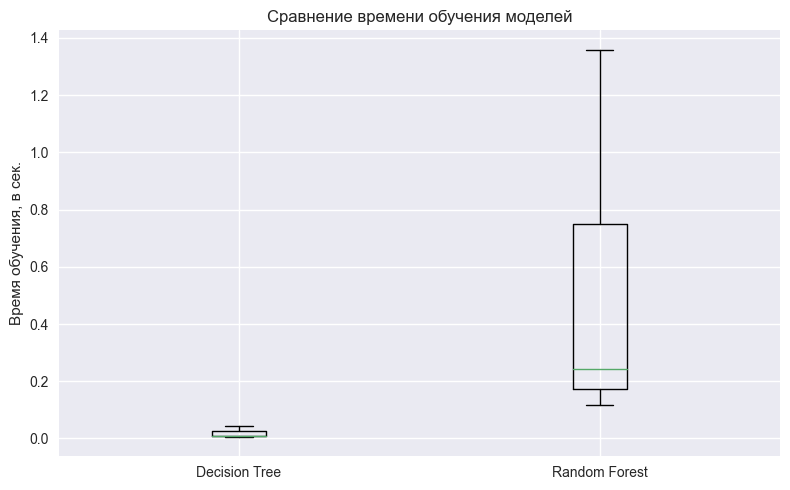

In [27]:
# Построение графика boxplot
plt.figure(figsize=(8, 5))
plt.boxplot([dt_fit_times[0], rf_fit_times[0]], labels=["Decision Tree", "Random Forest"])
plt.ylabel("Время обучения, в сек.")
plt.title("Сравнение времени обучения моделей")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Время обучения рассматриваемых моделей:
- **Decision Tree** обучается **очень быстро**: ~0.03–0.04 секунды. Разброс времени низкий (так как один классификатор, простая структура)
- **Random Forest** требует **намного больше времени**: ~0.2–1.3 секунды. Разброс времени высокий (так как обучается несколько деревьев, каждый на бутстрап-выборке, с учётом max_features)

#### Почему такие результаты?
- `RandomForest` — ансамбль из 50 деревьев, каждый строится независимо, но требует больше вычислений. Разброс связан с тем, что каждый запуск строит **разные деревья** из-за случайных подвыборок.
- `DecisionTree` строится один раз, поэтому стабилен и очень быстрый.

#### Как можно ускорить обучение?
1. Уменьшить `n_estimators` в `RandomForest`
2. Уменьшить `max_depth`
3. Ограничить `max_features` (например, `"sqrt"`)

## Сравнение результатов

Сравните результаты алгоритмов. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

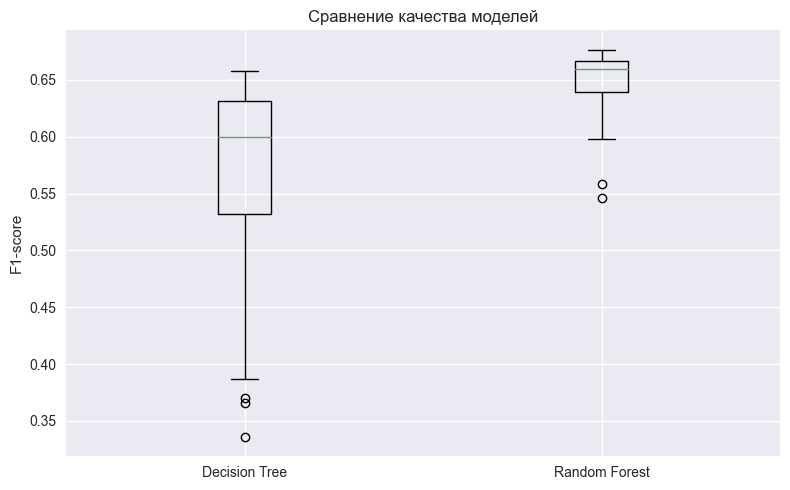

In [28]:
# your code here
# Построение графика boxplot
plt.figure(figsize=(8, 5))
plt.boxplot([dt_fit_score[0], rf_fit_score[0]], labels=["Decision Tree", "Random Forest"])
plt.ylabel("F1-score")
plt.title("Сравнение качества моделей")
plt.grid(True)
plt.tight_layout()
plt.show()

### Сравнение моделей:
- **Random Forest** стабильно показывает более высокое и менее разбросанное значение F1-score.
- **Decision Tree** имеет больше выбросов и большую вариативность — что говорит о меньшей устойчивости.
- Сложная модель Random Forest работает лучше с учетом нелинейных зависимостей и переобучения. Гиперпараметры у Random Forest влияют меньше — модель более устойчива.

### **Итоговые выводы о классификаторах**

В рамках эксперимента были рассмотрены два алгоритма машинного обучения: **Decision Tree** и **Random Forest**, с подбором гиперпараметров и последующей оценкой по метрике **f1-score**.

#### **1. Качество классификации**
- **Random Forest** показал **наивысшую точность** (≈ 0.65–0.68) и более **устойчивые результаты** на кросс-валидации.
- **Decision Tree** уступает по качеству (≈ 0.613) и демонстрирует больший разброс, что указывает на чувствительность к выбору обучающей выборки.

#### **2. Влияние гиперпараметров**
- У **Decision Tree** ключевым гиперпараметром является `max_depth`. При недостаточной глубине дерево не обучается, а при слишком большой — переобучается.
- У **Random Forest** значительное влияние оказывают:
  - `n_estimators` — влияет на стабильность, но увеличивает время обучения.
  - `max_depth` — регулирует сложность отдельных деревьев.
  - `max_features` — определяет разнообразие деревьев, снижая переобучение.

#### **3. Время обучения**
- **Decision Tree** обучается за доли секунды и подходит для быстрого прототипирования.
- **Random Forest** требует значительно больше времени (в среднем ~1.2 секунды), особенно при большом количестве деревьев, но выигрывает в качестве и устойчивости.


## Тестирование всех модели

Протестируйте последние построенные модели (наилучшее решающее дерево и наилучший случайный лес) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [29]:
# your code here
# Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
test_df['capital-gain'] = np.log(test_df['capital-gain']+1)
test_df['capital-loss'] = np.log(test_df['capital-loss']+1)
test_df['fnlwgt'] = np.log(test_df['fnlwgt']+1)

# Преобразуем тестовый целевой признак к бинарному типу данных
test_df['>50K,<=50K'] = test_df['>50K,<=50K'].apply(lambda x: 1 if x == '>50K' else 0)
test_df['>50K,<=50K'].value_counts()

y_test = test_df[target_column]
X_test = test_df.drop(columns=[target_column])

X_test_encoded = pd.get_dummies(X_test)
X_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6139 entries, 8391 to 6721
Data columns (total 63 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   6139 non-null   int64  
 1   fnlwgt                                6139 non-null   float64
 2   education-num                         6139 non-null   int64  
 3   capital-gain                          6139 non-null   float64
 4   capital-loss                          6139 non-null   float64
 5   hours-per-week                        6139 non-null   int64  
 6   workclass_Federal-gov                 6139 non-null   uint8  
 7   workclass_Local-gov                   6139 non-null   uint8  
 8   workclass_Private                     6139 non-null   uint8  
 9   workclass_Self-emp-inc                6139 non-null   uint8  
 10  workclass_Self-emp-not-inc            6139 non-null   uint8  
 11  workclass_Stat

In [30]:
# Обучение и предсказание лучших моделей
dt_best = tree.DecisionTreeClassifier(criterion="gini", max_depth=9, max_features=None, random_state=42)
rf_best = ensemble.RandomForestClassifier(criterion="gini", max_depth=15, max_features=None, n_estimators=50, random_state=42, n_jobs=-1)

dt_best.fit(X_encoded, y_train)
rf_best.fit(X_encoded, y_train)

y_dt_pred = dt_best.predict(X_test_encoded)
y_rf_pred = rf_best.predict(X_test_encoded)

# F1-score на тестовой выборке
dt_test_acc = f1_score(y_test, y_dt_pred)
rf_test_acc = f1_score(y_test, y_rf_pred)

dt_test_acc, rf_test_acc

(0.6711220541681322, 0.6838311019567456)

#### **F1-score на тесте**:
- **Decision Tree** = **`0.6711`**
- **Random Forest** = **`0.6838`**

#### **Выводы**:
1. **Random Forest** показывает **лучшую обобщающую способность**, его F1-score немного выше. Он устойчивее и лучше справляется с перекрытием классов за счёт ансамбля деревьев.
3. **Decision Tree** проигрывает по качеству, но работает быстрее и проще в интерпретации — может быть полезна, если важна интерпретируемость модели.